In [8]:
%load_ext autoreload
%autoreload 2
import os
import glob
import json

outs = {}


for filename in sorted([f for f in glob.glob("../output/*.json") if "test" not in f]): 
    model_name = os.path.basename(filename).split(".")[0]
    print(model_name)
    with open(filename) as f:
        outs[model_name] = json.load(f)
        print(len(outs[model_name]["hate"]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
bertin
15
beto-cased-10000
15
beto-cased-20000
15
beto-cased-2500
15
beto-cased-5000
15
beto-cased
15
beto-uncased-10000
15
beto-uncased-20000
15
beto-uncased-2500
15
beto-uncased-5000
15
beto-uncased
15
roberta-bne
15
robertuito-cased
15
robertuito-deacc
15
robertuito-uncased-200k
5
robertuito-uncased
15


## Barplots

In [14]:
import pandas as pd

models = [
    "beto-uncased", "beto-uncased-2500", "beto-uncased-5000", "beto-uncased-10000", "beto-uncased-20000",
    "beto-cased", "beto-cased-2500", "beto-cased-5000", "beto-cased-10000", "beto-cased-20000",
    "robertuito-uncased", "robertuito-cased", "robertuito-deacc",
]
task_metrics = {
    "context_hate": "eval_mean_f1",
    "hate": "eval_macro_f1",
    "sentiment": "eval_macro_f1",
    "emotion": "eval_macro_f1",
    "irony": "eval_macro_f1",
}

task_names = {
    "context_hate": "CONTEXTO",
    "hate": "ODIO",
    "sentiment": "SENTIMENTO",
    "emotion": "EMOCIÓN",
    "irony": "IRONÍA",
}

dfs = []

for model in models: 
    model_df = pd.DataFrame({
        task_names[task]: [100*run[column] for run in outs[model][task]]
        for task, column in task_metrics.items()
    })

    model_df["model"] = model
    model_df["case"] = "cased" if "-cased" in model else "uncased" 
    dfs.append(model_df)

df = pd.concat(dfs)

In [15]:
melted_df = df.melt(id_vars=["model", "case"], var_name="task", value_name="score")

melted_df

,model,case,task,score
0,beto-uncased,uncased,CONTEXTO,58.155417
1,beto-uncased,uncased,CONTEXTO,59.553963
2,beto-uncased,uncased,CONTEXTO,58.562458
3,beto-uncased,uncased,CONTEXTO,59.601653
4,beto-uncased,uncased,CONTEXTO,58.896869
...,...,...,...,...
970,robertuito-deacc,uncased,IRONÍA,73.864061
971,robertuito-deacc,uncased,IRONÍA,74.106359
972,robertuito-deacc,uncased,IRONÍA,75.190139
973,robertuito-deacc,uncased,IRONÍA,73.715562


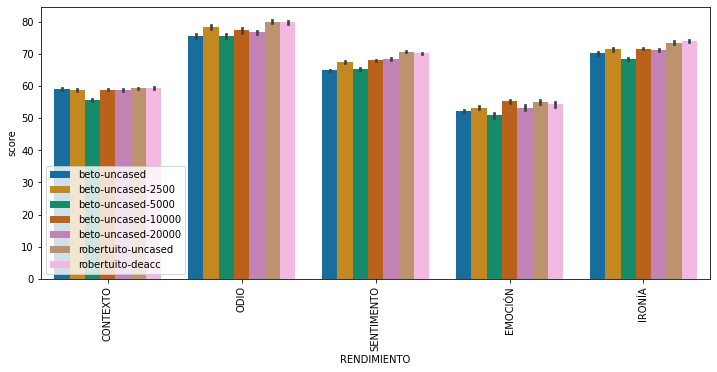

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

uncased_models = melted_df[melted_df.case == "uncased"]

palette= "colorblind"

sns.barplot(
    x="task", y="score", hue="model", data=uncased_models,
    palette=palette,
)

plt.legend(loc="lower left")
plt.xlabel("TAREA")
plt.xlabel("RENDIMIENTO")
plt.xticks(rotation=90) 

plt.savefig("img/results_uncased_models.pdf", bbox_inches="tight")

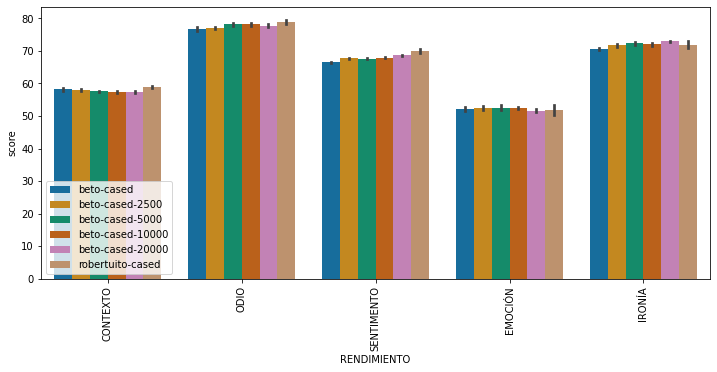

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

cased_models = melted_df[melted_df.case == "cased"]

ax = sns.barplot(
    x="task", y="score", hue="model", data=cased_models,
    palette=palette,
)

plt.legend(loc="lower left")
plt.xlabel("TAREA")
plt.xlabel("RENDIMIENTO")
plt.xticks(rotation=90) 


plt.savefig("img/results_cased_models.pdf", bbox_inches="tight")

In [23]:
import pandas as pd
import numpy as np

resume = []
mean_resume = []
task_metrics = {
    "context_hate": ["eval_mean_f1", "eval_hate_f1"],
    "hate": ["eval_hateful_f1", "eval_macro_f1"],
    "sentiment": ["eval_macro_f1", "eval_micro_f1"],
    "emotion": ["eval_macro_f1", "eval_micro_f1"],
    "irony": ["eval_ironic_f1", "eval_macro_f1"],
}

    
for model_name, output in outs.items():
    line = {
        "model": model_name, 
    }

    mean_line = {
        "model": model_name,
    }

    for task, metrics in task_metrics.items():
        try:
            for metric in metrics:
                arr = np.array([100*evaluation[metric] for evaluation in output[task]])
                metric_name = metric.replace("eval_", "")
                mean_line[task+" "+metric_name] = arr.mean()
                line[task+" "+metric_name] = f"{arr.mean():.3f} +- {arr.std():.3f}"
        except KeyError as e:
            print(e, "not in ", model_name)
            continue
    resume.append(line)
    mean_resume.append(mean_line)

order = [
    "bertin",
    "roberta-bne",
    "beto-uncased",
    # Nos quedamos con uncased-10000 que es el mejor
    #"beto-uncased-2500",
    #"beto-uncased-5000",
    "beto-uncased-10000",
    #"beto-uncased-20000",
    "robertuito-uncased",
    #"robertuito-deacc-288k",
    #"robertuito-deacc-344k",
    #"robertuito-deacc-400k",
    #"robertuito-deacc-440k",
    #"robertuito-deacc-490k",
    #"robertuito-deacc-510k",
    #"robertuito-deacc-540k",
    #"robertuito-deacc-576k",
    #"robertuito-deacc-592k",
    "robertuito-deacc",
    #"checkpoint-46k",
    #"checkpoint-62k",
    #"checkpoint-87k",
    #"checkpoint-100k",
    #"checkpoint-124k",
    #"robertuito-uncased-200k",
    "beto-cased",
    #"beto-cased-2500",
    #"beto-cased-5000",
    #"beto-cased-10000",
    "beto-cased-20000",
    "robertuito-cased",
]


df = pd.DataFrame(resume)
df.set_index("model", inplace=True)

df_mean = pd.DataFrame(mean_resume).set_index("model")
score_cols = ["context_hate mean_f1", "hate macro_f1", "sentiment macro_f1", "emotion macro_f1", "irony macro_f1"]
score_without_chate_cols = ["hate macro_f1", "sentiment macro_f1", "emotion macro_f1", "irony macro_f1"]

df.loc[order, "score"] = df_mean.loc[order, score_cols].mean(axis=1)
df.loc[order, "score2"] = df_mean.loc[order, score_without_chate_cols].mean(axis=1)
columns = [c for c in df.columns if "micro" not in c and "score" not in c] + ["score", "score2" ]

df.loc[order, score_cols + ["score", "score2"]].sort_values("score", ascending=False)

,context_hate mean_f1,hate macro_f1,sentiment macro_f1,emotion macro_f1,irony macro_f1,score,score2
model,,,,,,,
robertuito-uncased,59.323 +- 0.424,80.127 +- 0.983,70.726 +- 0.394,55.051 +- 1.079,73.588 +- 0.815,67.762908,69.873008
robertuito-deacc,59.314 +- 0.556,79.837 +- 0.818,70.175 +- 0.398,54.330 +- 1.475,73.991 +- 0.553,67.529290,69.583189
robertuito-cased,58.951 +- 0.543,78.980 +- 1.232,70.058 +- 1.226,51.887 +- 3.168,71.946 +- 2.318,66.364197,68.217593
beto-uncased-10000,58.848 +- 0.297,77.506 +- 1.525,67.989 +- 0.425,55.305 +- 0.909,71.670 +- 0.543,66.263667,68.117627
beto-cased-20000,57.245 +- 0.596,77.713 +- 0.883,68.643 +- 0.484,51.676 +- 0.901,72.968 +- 0.396,65.648685,67.749709
roberta-bne,57.731 +- 0.355,76.575 +- 1.476,66.864 +- 0.640,53.306 +- 1.105,72.307 +- 1.690,65.356500,67.262999
beto-cased,58.195 +- 0.699,76.801 +- 1.223,66.489 +- 0.393,52.144 +- 1.180,70.603 +- 0.705,64.846488,66.509315
bertin,55.694 +- 0.754,76.722 +- 0.533,66.493 +- 0.310,51.847 +- 1.242,71.594 +- 0.781,64.470230,66.664220
beto-uncased,59.073 +- 0.618,75.657 +- 1.219,64.883 +- 0.454,52.123 +- 0.608,70.172 +- 0.786,64.381711,65.708900


In [24]:
print(df.loc[order, score_cols + ["score"]].sort_values("score").to_markdown())

| model              | context_hate mean_f1   | hate macro_f1   | sentiment macro_f1   | emotion macro_f1   | irony macro_f1   |   score |
|:-------------------|:-----------------------|:----------------|:---------------------|:-------------------|:-----------------|--------:|
| beto-uncased       | 59.073 +- 0.618        | 75.657 +- 1.219 | 64.883 +- 0.454      | 52.123 +- 0.608    | 70.172 +- 0.786  | 64.3817 |
| bertin             | 55.694 +- 0.754        | 76.722 +- 0.533 | 66.493 +- 0.310      | 51.847 +- 1.242    | 71.594 +- 0.781  | 64.4702 |
| beto-cased         | 58.195 +- 0.699        | 76.801 +- 1.223 | 66.489 +- 0.393      | 52.144 +- 1.180    | 70.603 +- 0.705  | 64.8465 |
| roberta-bne        | 57.731 +- 0.355        | 76.575 +- 1.476 | 66.864 +- 0.640      | 53.306 +- 1.105    | 72.307 +- 1.690  | 65.3565 |
| beto-cased-20000   | 57.245 +- 0.596        | 77.713 +- 0.883 | 68.643 +- 0.484      | 51.676 +- 0.901    | 72.968 +- 0.396  | 65.6487 |
| beto-uncased-10000 | 58.8

In [25]:
import pandas as pd
import numpy as np

resume = []
mean_resume = []
task_metrics = {
    "context_hate": ["eval_mean_f1", "eval_hate_f1"],
    "hate": ["eval_hateful_f1", "eval_macro_f1"],
    "sentiment": ["eval_macro_f1", "eval_micro_f1"],
    "emotion": ["eval_macro_f1", "eval_micro_f1"],
}

    
for model_name, output in outs.items():
    line = {
        "model": model_name, 
    }

    mean_line = {
        "model": model_name,
    }

    for task, metrics in task_metrics.items():
        try:
            for metric in metrics:
                arr = np.array([evaluation[metric] for evaluation in output[task]])
                metric_name = metric.replace("eval_", "")
                mean_line[task+" "+metric_name] = arr.mean()
                line[task+" "+metric_name] = f"{arr.mean():.4f} +- {arr.std():.3f}"
        except KeyError as e:
            print(e, "not in ", model_name)
            continue
    resume.append(line)
    mean_resume.append(mean_line)

order = [
    "bertin",
    "beto-cased",
    "beto-uncased",
    "beto-ft-1000",
    "beto-ft-2000",
    "beto-uncased-1000",
    "beto-uncased-2000",
    "beto-uncased-5000",
    "beto-uncased-5000-grito",
    "beto-uncased-4000-tpu",
    "beto-uncased-5000-tpu",
    "beto-uncased-15000",
    "beto-uncased-15000-last",
    "beto-cased-15000",
]


df = pd.DataFrame(resume)
df.set_index("model", inplace=True)

df_mean = pd.DataFrame(mean_resume).set_index("model")
score_cols = ["context_hate mean_f1", "hate hateful_f1", "sentiment macro_f1", "emotion macro_f1"]

df.loc[order, "score"] = df_mean.loc[order, score_cols].mean(axis=1)
columns = [c for c in df.columns if "micro" not in c]

df.loc[order, columns]

KeyError: "['beto-ft-1000', 'beto-ft-2000', 'beto-uncased-1000', 'beto-uncased-2000', 'beto-uncased-5000-grito', 'beto-uncased-4000-tpu', 'beto-uncased-5000-tpu', 'beto-uncased-15000', 'beto-uncased-15000-last', 'beto-cased-15000'] not in index"

- "last" es usando los mismos parámetros que en el paper de finetuning

No parecen ser los mejores!
